# Mental Health Sentiment Analysis
### Capstone Project for Flatiron School Data Science Program
### By Matthew Gulbin

For this project, I decided to research social media sentiment analysis, particularly through the lens of mental health. To that end, I trained machine learning models to try to predict mental health conditions (anxiety, depression, etc.) based on text input from a user. 

This project is made up primarily by two files: this notebook, where I performed the data cleaning, modeling, and tuning, and a Python file for a web app that I built using Streamlit that allows the user to enter text and receive a prediction from the model.

## Data Cleaning/Prep

First, let's import our neccessary packages

In [1]:
import pandas as pd
import nltk
import torch
from datasets import Dataset
from transformers import BertTokenizer
import numpy as np
from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read the data to a dataframe from the file

In [2]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)

In [3]:
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [4]:
df['status'].value_counts(normalize=True)

status
Normal                  0.308259
Depression              0.290406
Suicidal                0.200837
Anxiety                 0.073299
Bipolar                 0.054239
Stress                  0.050318
Personality disorder    0.022642
Name: proportion, dtype: float64

Now we'll do data cleaning. First we'll drop all of the nulls

In [5]:
df = df.dropna()

Now let's save all of the possible statuses to a list, and create dictionaries mapping them to ids and back

In [6]:
labels = df['status'].unique().tolist()
labels

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [7]:
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

label_to_id['Suicidal']
id_to_label[3]

'Suicidal'

In [8]:
df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_72329/1510116700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])


Let's format the dataframe so that it's compatable with huggingface

In [9]:
df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})
df

,text,labels
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


For the purpose of training, we will take a random sample of 5000 entries

In [10]:
df = df.sample(5000, random_state=42)
df

,text,labels
3008,I'm lazy to complain about it ba ihh,1
44705,i think the wifi on my iphone is broken it wil...,1
50186,Good tracking apps? I've been trying to find a...,5
13755,I have recently looked into reddit and found t...,2
32298,that's your favorite thing to do?,1
...,...,...
46638,"I Am a Colorful Portrait of Bipolar, ADHD, Anx...",5
34815,Hi I’m new - hypochondriac for 3 years. Hi eve...,0
45559,"Best meds for me, I guess Lithium was the best...",5
38088,a year ago today i moved to a new city the cit...,2


Now we do our train test split

In [11]:
train_df, val_df = train_test_split(df, test_size=.2, random_state=42)

## Traditional Model (Multinominal NB)

For the purpose of comparison, let's make a traditional ML model, in this case a multinominal Naive Bayes.

In [175]:
X_train = train_df['text']
X_test = val_df['text']
y_train = train_df['labels']
y_test = val_df['labels']

Here, we use regular expressions to clean our text

In [176]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [178]:
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

Now that the text has been preprocessed, we can now feed it into transformers and then a model. In the pipeline below, we will use a Count Vectorizer and then a TF-IDF Vectorizer to transform the texts and then feed them into a Multinominal Naive-Bayes. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [180]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [181]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

In [185]:
y_pred = text_clf.predict(X_test)
f1_score_mnb = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

Now that we have our prediction, let's see how our model performed

In [186]:
print(f"Model F1: {f1_score_mnb:.2f}")
print("\nClassification Report:")
print(report)

Model Accuracy: 0.16

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.94      0.42      0.58       318
           2       0.34      0.98      0.51       296
           3       0.86      0.03      0.06       207
           4       0.00      0.00      0.00        51
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00        18

    accuracy                           0.43      1000
   macro avg       0.31      0.20      0.16      1000
weighted avg       0.58      0.43      0.34      1000



As we can see, the tradional model results in an F1 score of 0.16. This could be due to a great amount of syntactic overlap between different mental health statuses, such as depression and suicidal. Let's take a look at the confusion matrix for this model.

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns

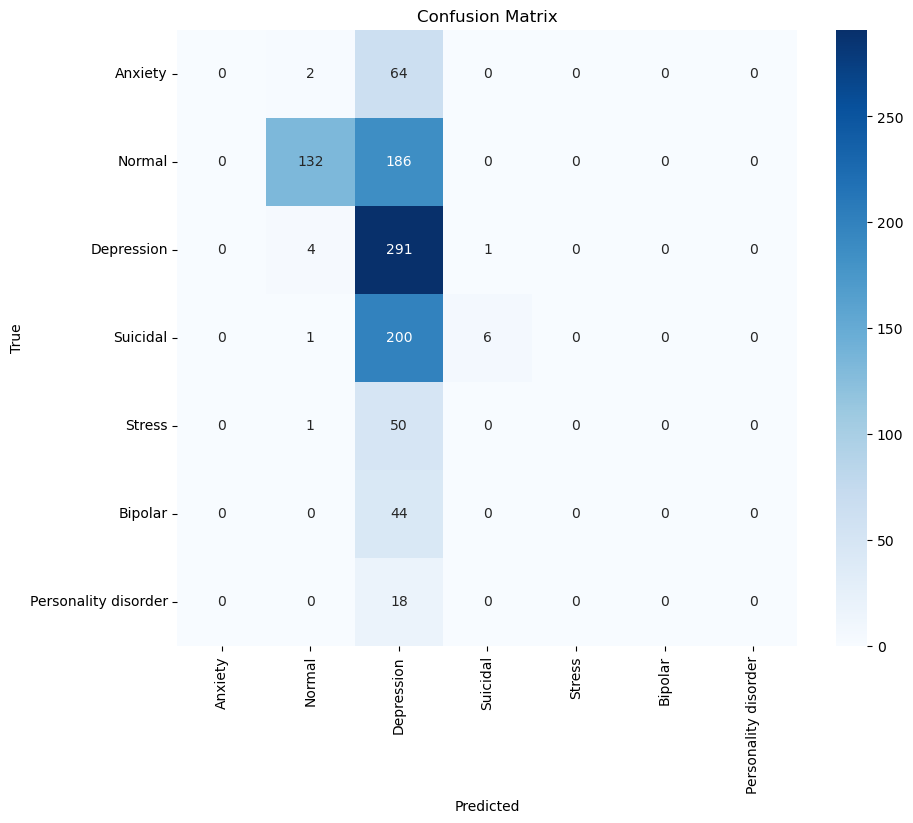

In [189]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [190]:
y_test.value_counts()

labels
1    318
2    296
3    207
0     66
4     51
5     44
6     18
Name: count, dtype: int64

## Transformer Neural Network (BERT)

Now, let's use a transformer neural network to tokenize and model our dataset. For this, we will use HuggingFace's different python libraries.

First, we have to transfer our dataframes into a Dataset, HuggingFace's data structure

In [12]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

### Initial Model (Default Parameters)

Before we start building the model, we have to tokenize our text, similar to the traditional model we built. In order to do this, we initialize a HuggingFace tokenizer object, which will let us utilize the BERT Transformer Neural Network to convert the text into tokens to feed into the model. To save compute time, we will be limiting the tokenized strings to 128 characters.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [15]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 1000/1000 [00:01<00:00, 812.27 examples/s]


In [16]:
len(tokenized_train['input_ids'][0])

128

Now, let's feed our tokenized data into a BertforSequenceClassification model, which is most suitable for a single label classification problem such as this.

In [17]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we have to initialize a TrainingArguments object, where we can specify the hyperparameters for the model. For this initial model, we'll keep a lot of these as default.

In [18]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Next, we initialize a metric object, where we'll initialize our scoring metric. As we did in the traditional model, we'll be using F1 Score as our evaluation metric.

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

Finally, we'll take the model, training arguments, datasets, and evaluator and pass them into a Trainer object. Then, we'll call that object's .train() function to actually train our initial model.

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.664834,0.653562
2,0.719300,0.552152,0.752375
3,0.719300,0.593442,0.739776
4,0.218300,0.710653,0.770705
5,0.218300,0.849994,0.771255


TrainOutput(global_step=1250, training_loss=0.38319299240112303, metrics={'train_runtime': 1516.3003, 'train_samples_per_second': 13.19, 'train_steps_per_second': 0.824, 'total_flos': 1315614336000000.0, 'train_loss': 0.38319299240112303, 'epoch': 5.0})

In [22]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.5521522760391235, 'eval_f1': 0.7523748175788224, 'eval_runtime': 19.0609, 'eval_samples_per_second': 52.463, 'eval_steps_per_second': 3.305, 'epoch': 5.0}


Even though the F1 reaches .77 in epoch #4, our evaluator shows that epoch #2 is the best performing model. This is because validation loss is at its lowest at this point, before it starts to increase in subsequent epochs, which is a sign of the model overfitting to the training data. So, the best performing initial model has an F1 score of .75, which is a substantial improvement over the initial Naive Bayes model.

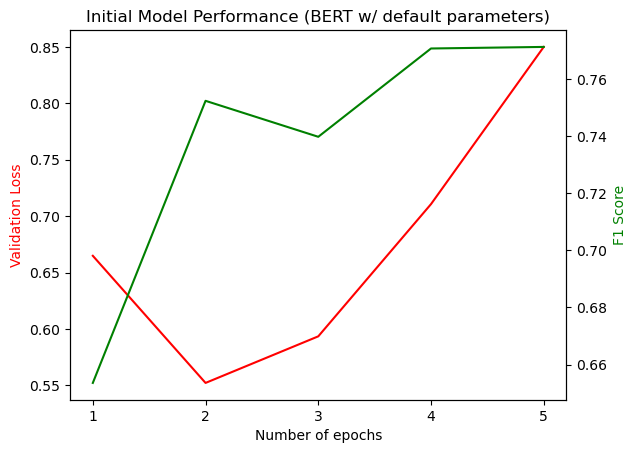

In [38]:
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
val_l_list = [0.664834, 0.552152, 0.593442, 0.710653, 0.849994]
f1_list = [0.653562, 0.752375, 0.739776, 0.770705, 0.771255]

fig, ax1 = plt.subplots()
ax1.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel('Validation Loss', c='r')

ax2 = ax1.twinx()

ax2.plot(epoch_list, f1_list, c='g', label='F1 Score')
ax2.set_ylabel("F1 Score", c="g")

plt.title("Initial Model Performance (BERT w/ default parameters)")
plt.xticks([1,2,3,4,5])
plt.show()

### Learning Rate and Weight Decay Tuning

Now, we'll start tuning our hyperparameters to improve the performance of the model. We'll be focusing on learning rate and weight decay first. Learning rate determines how quickly the weights change over the course of training, while weight decay penalizes unusually high wieghts in the model. Let's make a model where learning rate = 2e-5 (.00002) and weight decay = 0.01.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

With these hyperparameters, the model starts overfitting after the first epoch, resulting in an optimal F1 score of 0.76. This is only a slight improvement over the initial BERT model, so we'll have to try different techniques to get a higher F1.

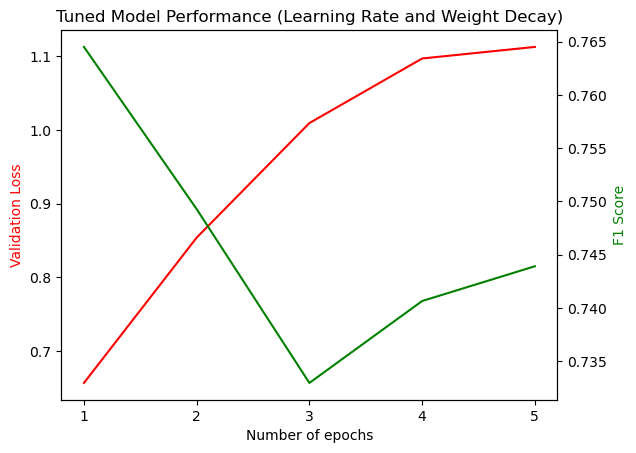

In [39]:
# with new learning rate and weight decay
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
val_l_list = [.656934, .853999, 1.009352, 1.096921, 1.112623]
f1_list = [0.764503, 0.749274, 0.732952, 0.740643, 0.743907]

fig, ax1 = plt.subplots()
ax1.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel('Validation Loss', c='r')

ax2 = ax1.twinx()

ax2.plot(epoch_list, f1_list, c='g', label='F1 Score')
ax2.set_ylabel("F1 Score", c="g")

plt.title("Tuned Model Performance (Learning Rate and Weight Decay)")
plt.xticks([1,2,3,4,5])
plt.show()

### Sample Size of 10k

In this model, we'll increase the sample size of our data from 5k to 10k, to attempt to improve the model further by simply having it train on more data.

In [ ]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)
df = df.dropna()

labels = df['status'].unique().tolist()

label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})

df = df.sample(10000, random_state=42)

train_df, val_df = train_test_split(df, test_size=.2, random_state=42)

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [ ]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Below, we'll load our evaluate metric that the model will use to score each epoch. Since we want to determine the ratio of accurate classifications, we'll use the F1 score to evaluate the model

In [18]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.934200,0.607324,0.602688
2,0.497900,0.551728,0.737671
3,0.333600,0.589579,0.751955
4,0.214300,0.648793,0.762547
5,0.131100,0.733130,0.756141


TrainOutput(global_step=2500, training_loss=0.42221019287109374, metrics={'train_runtime': 4739.9814, 'train_samples_per_second': 8.439, 'train_steps_per_second': 0.527, 'total_flos': 2631228672000000.0, 'train_loss': 0.42221019287109374, 'epoch': 5.0})

In [21]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.5517283082008362, 'eval_f1': 0.7376706086526598, 'eval_runtime': 37.5823, 'eval_samples_per_second': 53.217, 'eval_steps_per_second': 3.326, 'epoch': 5.0}


The model seems to start overfitting at arround epoch #3 because validation loss starts to increase. This results in this model's F1 score being about 0.73, which is about the same as the other BERT models we've trained. Next, let's try a different sampling technique that will compensate for one of the underlying flaws in the dataset.

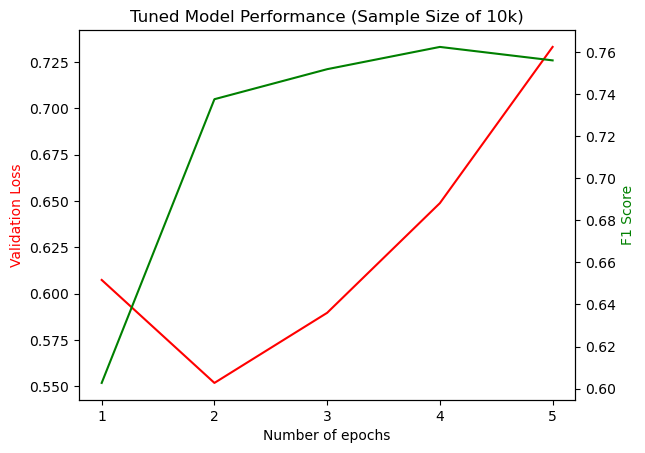

In [41]:
# with sample size of 10k
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
val_l_list = [0.607324, 0.551728, 0.589579, 0.648793, 0.733130]
f1_list = [0.602688, 0.737671, 0.751955, 0.762547, 0.756141]

fig, ax1 = plt.subplots()
ax1.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel('Validation Loss', c='r')

ax2 = ax1.twinx()

ax2.plot(epoch_list, f1_list, c='g', label='F1 Score')
ax2.set_ylabel("F1 Score", c="g")

plt.title("Tuned Model Performance (Sample Size of 10k)")
plt.xticks([1,2,3,4,5])
plt.show()

Here, we save our model and label mappings to files to be used in the Streamlit app

In [22]:
model.save_pretrained('./model/bigger')
tokenizer.save_pretrained('./model/bigger')

('./model/bigger/tokenizer_config.json',
 './model/bigger/special_tokens_map.json',
 './model/bigger/vocab.txt',
 './model/bigger/added_tokens.json')

In [23]:
import json
with open("./model/bigger/label_mapping.json", "w") as f:
    json.dump({"id_to_label": id_to_label, "label_to_id": label_to_id}, f)

## Undersampling

One of the issues with this dataset is the class imbalance, with most of the examples being categorized as "depression" "anxiety" or "suicidal". In an attempt to solve this and further improve the performance of the model, we will train the model on an undersampled dataset, where all classes have the same number of posts.

In [29]:
df = pd.read_csv("./data/Combined Data.csv", index_col=0)

In [30]:
df = df.dropna()

In [53]:
labels = df['status'].unique().tolist()
labels

['Anxiety',
 'Normal',
 'Depression',
 'Suicidal',
 'Stress',
 'Bipolar',
 'Personality disorder']

In [54]:
label_to_id = {label: i for i, label in enumerate(labels)}
id_to_label = {i: label for i, label in enumerate(labels)}

label_to_id['Suicidal']
id_to_label[3]

'Suicidal'

In [33]:
df['status'] = df['status'].apply(lambda x : label_to_id[str(x)])

In [57]:
df = df.rename(columns={'statement' : 'text', 'status' : 'labels'})
df

,text,labels
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


In [58]:
#df = df.sample(5000, random_state=42)
df

,text,labels
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,0
53039,"selfishness ""I don't feel very good, it's lik...",0
53040,Is there any way to sleep better? I can't slee...,0
53041,"Public speaking tips? Hi, all. I have to give ...",0


In [59]:
df['labels'].value_counts()

labels
1    16343
2    15404
3    10652
0     3841
5     2777
4     2587
6     1077
Name: count, dtype: int64

In [75]:
df[df['labels'] == 6]

,text,labels
50654,Is there anyone interested in joining a group ...,6
50656,Anyone else have nothing in common with other ...,6
50657,Being a ghost would be my ideal form of existe...,6
50659,I am hurting Lately I just feel like garbage. ...,6
50660,I can't cope with my job I work from home as a...,6
...,...,...
51849,Could you change and get better through lots o...,6
51851,How to not hurt peoples feelings I think I’m d...,6
51852,Do you have goals? I realised that I never rea...,6
51853,I feel like I’ve missed out on my teenage year...,6


Here, we'll resample the dataset so that every class has the same number of samples as the minority class (1077)

In [60]:
balanced_df = df.groupby('labels', as_index=False, group_keys=False).apply(lambda s : s.sample(1077, replace=True))
balanced_df['labels'].value_counts()

/var/folders/4s/pf1zdv_x4_qcflpq4m943q0m0000gn/T/ipykernel_72876/2704669417.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('labels', as_index=False, group_keys=False).apply(lambda s : s.sample(1077, replace=True))


labels
0    1077
1    1077
2    1077
3    1077
4    1077
5    1077
6    1077
Name: count, dtype: int64

In [61]:
train_df, val_df = train_test_split(balanced_df, test_size=.2, random_state=42)

In [62]:
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [64]:
def tokenize_function(examples):
    #return tokenizer(examples["text"], padding="max_length", truncation=True)
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

In [65]:
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)

Map: 100%|██████████| 1508/1508 [00:02<00:00, 716.88 examples/s]


In [66]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer

# Initialize model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(labels)
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [67]:
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

/opt/anaconda3/envs/mental_health_proj/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [68]:
import numpy as np
import evaluate

metric = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [69]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

Now, we'll use this resampled data and train the model using the optimal parameters we determined previously

In [70]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.694737,0.741602
2,1.035600,0.575308,0.804124
3,0.425000,0.571271,0.810868
4,0.227000,0.577744,0.818549
5,0.227000,0.610594,0.821992


TrainOutput(global_step=1885, training_loss=0.4747196490948017, metrics={'train_runtime': 3626.4986, 'train_samples_per_second': 8.315, 'train_steps_per_second': 0.52, 'total_flos': 1983617515104000.0, 'train_loss': 0.4747196490948017, 'epoch': 5.0})

In [71]:
evaluation_results = trainer.evaluate()
print(f"Evaluation results: {evaluation_results}")

Evaluation results: {'eval_loss': 0.5712706446647644, 'eval_f1': 0.8108678252015726, 'eval_runtime': 28.1462, 'eval_samples_per_second': 53.577, 'eval_steps_per_second': 3.375, 'epoch': 5.0}


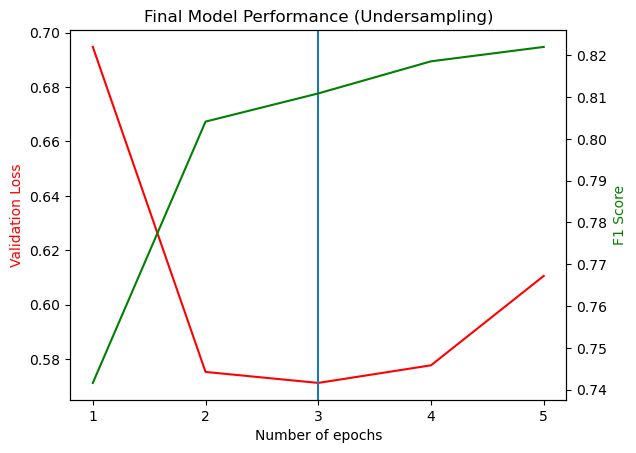

In [43]:
import matplotlib.pyplot as plt

epoch_list = [1,2,3,4,5]
val_l_list = [0.694737, 0.575308, 0.571271, 0.577744, 0.610594]
f1_list = [0.741602, 0.804124, 0.810868, 0.818549, 0.8219925]

fig, ax1 = plt.subplots()
ax1.plot(epoch_list, val_l_list, c='r', label='Validation Loss')
ax1.set_xlabel("Number of epochs")
ax1.set_ylabel('Validation Loss', c='r')
ax1.axvline(3)

ax2 = ax1.twinx()

ax2.plot(epoch_list, f1_list, c='g', label='F1 Score')
ax2.set_ylabel("F1 Score", c="g")

plt.title("Final Model Performance (Undersampling)")
plt.xticks([1,2,3,4,5])
plt.show()

Using the undersampled data, we've achieved an F1 score of 0.81, our highest thus far. Now let's save this model for use in our web app.

In [72]:
model.save_pretrained('./model/final')
tokenizer.save_pretrained('./model/final')

('./model/final/tokenizer_config.json',
 './model/final/special_tokens_map.json',
 './model/final/vocab.txt',
 './model/final/added_tokens.json')

In [74]:
import json
with open("./model/final/label_mapping.json", "w") as f:
    json.dump({"id_to_label": id_to_label, "label_to_id": label_to_id}, f)

## Web Application

As part of this project, I also created a very simple web app using Streamlit that allows users to input their own text and receive a mental health prediction from the model. The source code for this app can be found in the file ```app.py``` and can be run on your computer by typing ```streamlit run app.py```

The web page consists of a text box where the user can input text and a label which will display the prediction from the model. As part of the app, I loaded the model from the folder where we saved it above (/model/final/) and created a function that would take text in, do some formatting, and return the output to the label on the page.

## Conclusion / Next Steps

In this notebook, we created several models to try to classify social media posts based on mental health labels. Our best performing model was a BERT Transformer Neural Network that utilized data undersampling to achieve an equal class balance.

In the future, I hope to improve this project further by implementing a weighting system to compensate for the class imbalance problem without removing a lot of the posts in the majority categories. I would also look to deploy the application that I made so that other users could use it.